<a href="https://colab.research.google.com/github/tuankhoin/MCEN90048-EEG-Grasp-and-Lift-Detection/blob/main/Khoi_Preprocess_0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<a target="_blank" href="https://colab.research.google.com/github/tuankhoin/MCEN90048-EEG-Grasp-and-Lift-Detection/blob/main/code.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

In [1]:
import os
import json
import zipfile
from pathlib import Path

try:
  # See if you are running on colab
  from google.colab import drive 

  # Download the dataset
  api_token = {"username":"tuankhoinguyen","key":"6b992b229c6a4d8f6a8b30d1c101507d"}
  kaggle_path = Path('/root/.kaggle')
  os.makedirs(kaggle_path, exist_ok=True)

  with open (kaggle_path/'kaggle.json', 'w') as handl:
      json.dump(api_token,handl)
  os.chmod(kaggle_path/'kaggle.json', 600)  
  !kaggle competitions download -c grasp-and-lift-eeg-detection

  # Unzipping datasets
  for z in ['grasp-and-lift-eeg-detection','train']:
    print(f'Unzipping {z}.zip')
    with zipfile.ZipFile(f'{z}.zip', 'r') as zip_ref:
      zip_ref.extractall('')
  print('All good!')
  # Removing the zip files to save up VM space
  !rm *.zip
except:
  pass

 99% 1.00G/1.02G [00:09<00:00, 160MB/s]
100% 1.02G/1.02G [00:09<00:00, 117MB/s]
Unzipping grasp-and-lift-eeg-detection.zip
Unzipping train.zip
All good!


In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

import glob
import tqdm
import pywt
import warnings
warnings.filterwarnings('ignore')

from collections import Counter

# Label Observation

In [47]:
events = glob.glob('/content/train/*_events.csv')

In [41]:
df_count = pd.DataFrame()

for e in tqdm.tqdm(events):
  df = pd.read_csv(e).iloc[:,1:]
  ct = df.value_counts()
  df_count = ct if df_count.empty else df_count.add(ct, fill_value=0)

df_count = df_count.reset_index(name='count').astype(int)
df_count['No. Activities'] = df_count.iloc[:,:-1].sum(axis=1)
df_count

100%|██████████| 96/96 [00:24<00:00,  3.96it/s]


,HandStart,FirstDigitTouch,BothStartLoadPhase,LiftOff,Replace,BothReleased,count,No. Activities
0,0,0,0,0,0,0,15687584,0
1,0,0,0,0,0,1,321905,1
2,0,0,0,0,1,0,321905,1
3,0,0,0,0,1,1,146095,2
4,0,0,0,1,0,0,388279,1
5,0,0,1,0,0,0,134690,1
6,0,0,1,1,0,0,49296,2
7,0,1,0,0,0,0,184452,1
8,0,1,0,1,0,0,204,2
9,0,1,1,0,0,0,253123,2


In [45]:
df_stats = df_count.groupby('No. Activities')['count'].sum().reset_index(name='Count (frames)')
df_stats['Time (seconds)'] = df_stats['Count (frames)'] / 500
df_stats

,No. Activities,Count (frames)
0,0,15687584
1,1,1819231
2,2,448718
3,3,30221


# Data observing & preprocessing

In [3]:
datas = glob.glob('/content/train/*_data.csv')

In [3]:
e = pd.read_csv('/content/train/subj3_series5_events.csv')

In [4]:
d = pd.read_csv('/content/train/subj3_series5_data.csv').iloc[:,1:]
d

,Fp1,Fp2,F7,F3,Fz,F4,F8,FC5,FC1,FC2,...,P7,P3,Pz,P4,P8,PO9,O1,Oz,O2,PO10
0,264,520,453,311,215,656,841,542,58,-265,...,280,22,348,242,301,20,203,331,10,205
1,256,504,453,306,223,642,887,556,56,-251,...,312,31,350,227,298,48,249,328,-5,204
2,272,535,473,274,232,671,935,450,34,-229,...,293,16,363,215,318,33,233,362,-3,230
3,310,537,464,304,227,666,847,413,52,-224,...,283,11,357,224,316,-18,218,354,19,200
4,279,535,445,298,218,671,878,462,60,-233,...,313,18,385,242,322,26,273,378,48,255
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
248567,162,127,509,290,62,496,130,341,64,20,...,411,184,167,179,153,255,464,179,-10,47
248568,163,158,498,298,73,511,149,327,62,19,...,434,217,185,205,203,305,501,242,73,114
248569,189,176,510,330,59,522,175,373,76,30,...,467,267,232,218,230,349,530,279,131,148
248570,194,181,520,323,60,497,161,381,48,11,...,471,258,235,215,257,340,532,248,83,107


In [5]:
pd.DataFrame({'Minimum':d.min(),'Maximum':d.max(),'Mean':d.mean(),'Standard Deviation':d.std()}).sample(5)

,Minimum,Maximum,Mean,Standard Deviation
Fz,-245,594,131.794486,127.003153
PO9,-1287,1092,69.329896,246.195717
P4,-613,943,174.887308,172.325154
TP10,-669,1541,343.530261,312.289211
TP9,-953,1218,192.018779,286.833862


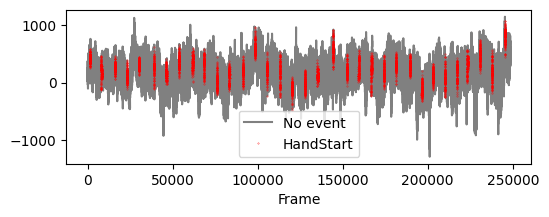

In [23]:
signal = d['O1']
idx = e[e['HandStart']==1].index
_,ax = plt.subplots(figsize = (6,2))
ax.plot(signal, 'gray')
ax.plot(idx,signal[idx], 'red', linestyle='None', marker='.', markersize=0.5)
ax.legend(['No event', 'HandStart'])
ax.set_xlabel('Frame')
plt.show()

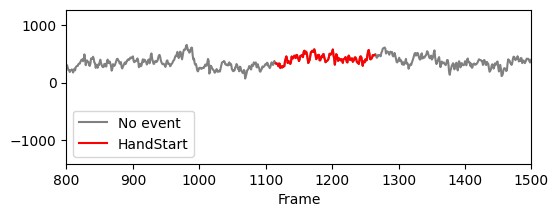

In [24]:
lim = 1500
_,ax = plt.subplots(figsize = (6,2))
ax.plot(signal, 'gray')
ax.plot(signal[[i for i in idx if i<lim]], 'red')
ax.legend(['No event', 'HandStart'])
ax.set_xlabel('Frame')
ax.set_xlim([800,lim])
plt.show()

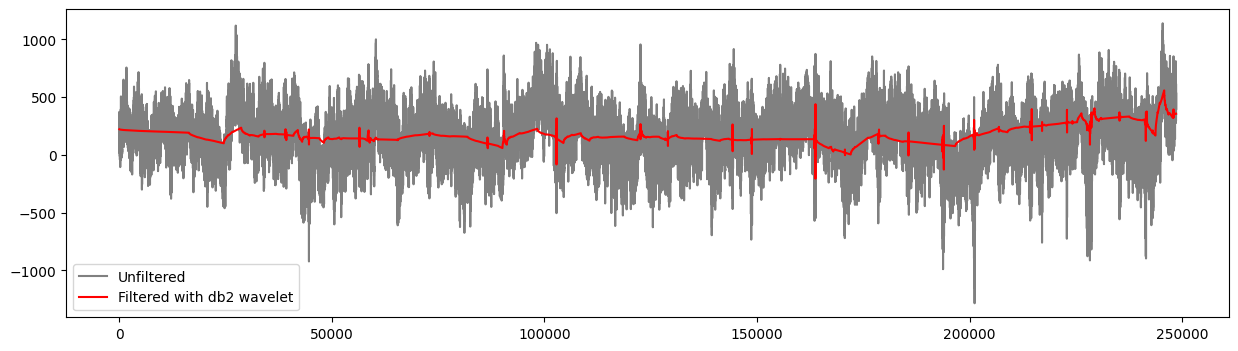

In [28]:
T=0.8
w='db2'

coeffs = pywt.wavedec(signal,w)
for i in range(1, len(coeffs)):
    coeffs[i] = pywt.threshold(coeffs[i], T*max(coeffs[i]))
rec = pywt.waverec(coeffs,w)

_,ax = plt.subplots(figsize=(15,4))
ax.plot(signal,'gray')
ax.plot(rec,'red')
#ax.plot(idx, rec[idx], 'red', linestyle='None', marker='.', markersize=0.5)
ax.legend(['Unfiltered', f'Filtered with {w} wavelet'])
#ax.set_xlim([100000,150000])
plt.show()